In [ ]:
import torch
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0) 
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets

In [ ]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train = False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [ ]:
need_train_indices = []
rest_train_indices = []
need_test_indices = []
rest_test_indices = []
for i in range(len(y_train)):
  if y_train[i] != 4 and y_train[i] != 7:
    need_train_indices.append(i)
  else:
    rest_train_indices.append(i)

for i in range(len(y_test)):
  if y_test[i] != 4 and y_test[i] != 7:
    need_test_indices.append(i)
  else:
    rest_test_indices.append(i)


In [ ]:
new_X_train = X_train[need_train_indices]
new_y_train = y_train[need_train_indices]
new_X_test = X_test[need_test_indices]
new_y_test = y_test[need_test_indices]
four_seven_train = X_train[rest_train_indices]
four_seven_y_train = y_train[rest_train_indices]
four_seven_test = X_test[rest_test_indices]
four_seven_y_test = y_test[rest_test_indices]
print(len(new_X_train))
print(len(X_train))
print(len(rest_train_indices))
print(len(rest_test_indices))

47893
60000
12107
2010


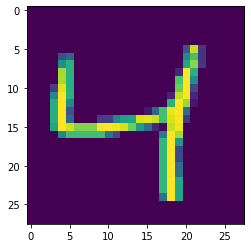

tensor(4)


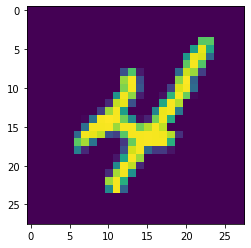

tensor(4)


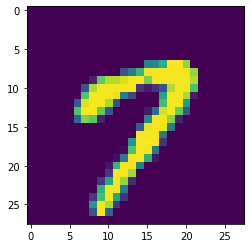

tensor(7)


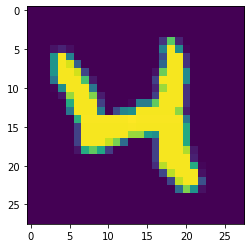

tensor(4)


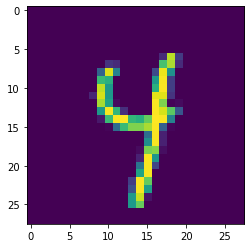

tensor(4)


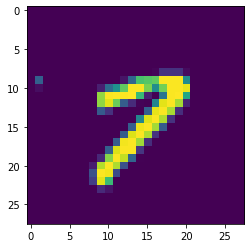

tensor(7)


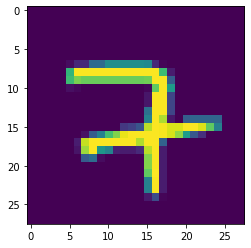

tensor(7)


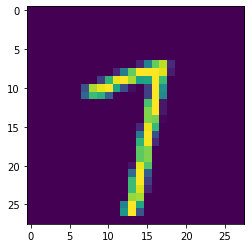

tensor(7)


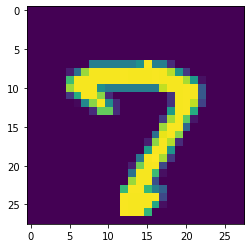

tensor(7)


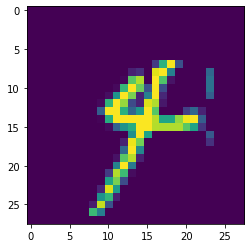

tensor(4)


In [ ]:
import matplotlib.pyplot as plt
for i in range(10):
  plt.imshow(four_seven_train[i,:,:])
  plt.show()
  print(four_seven_y_train[i])

In [ ]:
new_X_train = new_X_train.unsqueeze(1).float()
new_X_test = new_X_test.unsqueeze(1).float()
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()
four_seven_train = four_seven_train.unsqueeze(1).float()
four_seven_test = four_seven_test.unsqueeze(1).float()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class YannLecun(torch.nn.Module):
  def __init__(self):
    super(YannLecun, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding= 2)
    self.act1 = torch.nn.Tanh()
    self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride = 2)

    self.conv2 = torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size= 5, padding= 0)
    self.act2 =torch.nn.Tanh()
    self.pool2 = torch.nn.AvgPool2d(kernel_size=2,stride= 2)

    self.fc1 = torch.nn.Linear(5*5*16, 120)
    self.act3 = torch.nn.Tanh()

    self.fc2 = torch.nn.Linear(120,84)
    self.act4 = torch.nn.Tanh()

    self.fc3_1 = torch.nn.Linear(84, 8)
    self.fc3_2 = torch.nn.Linear(84, 2)
    #self.fc3 = torch.nn.Lniear(84,10)
    self.ident = torch.nn.Identity(10,10)
    #один слой разделим на два Linear(84,2) Linear(84,8)
    #и будем смотреть максимум по двум слоям 
    #
  def forward(self,x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)

    x = x.view(x.size(0),x.size(1)*x.size(2)*x.size(3))

    x = self.fc1(x)
    x = self.act3(x)
    x = self.fc2(x)
    x = self.act4(x)
    x1 = self.fc3_1(x)
    x1 = x1.to(device)
    x2 = self.fc3_2(x)
    x2 = x2.to(device)
    tot_x = torch.zeros((len(x),10), dtype=torch.float)
    tot_x = tot_x.to(device)
    indices_1 = [0,1,2,3,5,6,8,9]
    indices_2 = [4,7]
    tot_x[:, indices_1] = x1
    tot_x[:, indices_2] = x2
    x = self.ident(tot_x)
    return x

yann_lecun = YannLecun()

In [ ]:
yann_lecun = yann_lecun.to(device)

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(yann_lecun.parameters(), lr=4.0e-4)

In [ ]:
print(four_seven_y_test)

tensor([7, 4, 4,  ..., 4, 7, 4])


In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

new_X_test = new_X_test.to(device)
new_y_test = new_y_test.to(device)

for epoch in range(30):
  order = np.random.permutation(len(new_X_train))
  for start_index in range(0,len(new_X_train), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index+batch_size]

    X_batch = new_X_train[batch_indexes].to(device)
    y_batch = new_y_train[batch_indexes].to(device)

    preds = yann_lecun.forward(X_batch)

    loss_value = loss(preds,y_batch)
    loss_value.backward()

    optimizer.step()
  
  test_preds = yann_lecun.forward(new_X_test)
  test_loss_history.append(loss(test_preds, new_y_test).data.cpu())

  accuracy = (test_preds.argmax(dim = 1) == new_y_test).float().mean().data.cpu()
  test_accuracy_history.append(accuracy)

  print(accuracy)

tensor(0.9732)
tensor(0.9797)
tensor(0.9831)
tensor(0.9865)
tensor(0.9876)
tensor(0.9865)
tensor(0.9895)
tensor(0.9891)
tensor(0.9899)
tensor(0.9897)
tensor(0.9904)
tensor(0.9891)
tensor(0.9904)
tensor(0.9890)
tensor(0.9894)
tensor(0.9914)
tensor(0.9916)
tensor(0.9924)
tensor(0.9909)
tensor(0.9909)
tensor(0.9907)
tensor(0.9917)
tensor(0.9906)
tensor(0.9912)
tensor(0.9877)
tensor(0.9914)
tensor(0.9910)
tensor(0.9914)
tensor(0.9909)
tensor(0.9921)


In [ ]:
test_preds = yann_lecun.forward(new_X_test)
for i in range(10):
  print(test_preds[i])
  print(new_y_test[i])

print(test_preds.shape)
accuracy = (test_preds.argmax(dim = 1) == new_y_test).float().mean().data.cpu()

tensor([  0.9096,   0.5902,  15.7328,  -2.3597,  -2.4647, -12.2812,   2.4929,
         -2.1584,   2.4755,  -7.4244], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(2, device='cuda:0')
tensor([-3.6165, 16.9398, -1.1262, -2.5645, -1.9233, -5.6649, -1.6096, -1.8615,
         0.8896, -0.8878], device='cuda:0', grad_fn=<SelectBackward>)
tensor(1, device='cuda:0')
tensor([16.4412, -8.0772, -0.9060, -2.5446, -2.1071, -0.6597,  1.9931, -1.9864,
        -2.0877, -0.5412], device='cuda:0', grad_fn=<SelectBackward>)
tensor(0, device='cuda:0')
tensor([-2.2944, 16.5234, -2.3438, -2.6299, -1.8747, -5.6225, -2.1315, -1.8238,
         1.0234, -0.3708], device='cuda:0', grad_fn=<SelectBackward>)
tensor(1, device='cuda:0')
tensor([-4.1301e+00, -1.2978e-02,  2.4078e+00, -1.4141e+00, -2.3823e+00,
        -4.1976e+00, -6.9334e+00, -2.4407e+00, -3.9941e-01,  1.4981e+01],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor(9, device='cuda:0')
tensor([-1.9729, -5.6910, -4.9078, -4.8417, -1.7749

In [ ]:
for name, param in yann_lecun.named_parameters():
  
  if name != 'fc3_2.weight' and name != 'fc3_2.bias':
    param.requires_grad = False
    
for name, param in yann_lecun.named_parameters():
  print(name,param)


optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, yann_lecun.parameters()), lr=4.0e-4)
#optimizer = torch.optim.Adam(yann_lecun.parameters(), lr=4.0e-4)

conv1.weight Parameter containing:
tensor([[[[ 0.0280,  0.0545, -0.1397, -0.0915, -0.0575],
          [ 0.0241, -0.0495,  0.1490, -0.0250,  0.0347],
          [-0.0864, -0.0347, -0.1710, -0.1530, -0.0503],
          [ 0.0703,  0.1449,  0.1389, -0.1366, -0.0556],
          [ 0.1775,  0.2897,  0.0561,  0.1792,  0.0506]]],


        [[[ 0.0282,  0.1785, -0.0731,  0.1011,  0.0779],
          [-0.1260,  0.0928, -0.1774, -0.1020, -0.2037],
          [-0.2782, -0.2770,  0.0362,  0.0015,  0.0457],
          [ 0.0931, -0.0806,  0.0101, -0.1355, -0.1315],
          [ 0.0828,  0.1889,  0.1561,  0.0449,  0.0231]]],


        [[[ 0.1437,  0.1996,  0.0996, -0.0043,  0.0613],
          [-0.0612,  0.0679, -0.1288, -0.1003, -0.0591],
          [ 0.1046,  0.0572, -0.1318,  0.0848,  0.1626],
          [-0.0283, -0.0906, -0.0602,  0.1042,  0.2649],
          [-0.2070, -0.1522,  0.0170,  0.1679,  0.1956]]],


        [[[ 0.1658,  0.0528, -0.1208,  0.0349, -0.1662],
          [-0.1512,  0.1922,  0.1600, -0.

In [ ]:
batch_size = 100
test_accuracy_history = []
last_test_accuracy_history = []
test_loss_history = []

four_seven_test = four_seven_test.to(device)
four_seven_y_test = four_seven_y_test.to(device)

for epoch in range(40):
  order = np.random.permutation(len(four_seven_train))
  for start_index in range(0,len(four_seven_train), batch_size):
    optimizer.zero_grad()

    batch_indexes = order[start_index:start_index+batch_size]

    X_batch = four_seven_train[batch_indexes].to(device)
    y_batch = four_seven_y_train[batch_indexes].to(device)

    preds = yann_lecun.forward(X_batch)

    loss_value = loss(preds,y_batch)
    loss_value.backward()

    optimizer.step()
  
  test_preds = yann_lecun.forward(four_seven_test)
  test_loss_history.append(loss(test_preds, four_seven_y_test).data.cpu())
  last_test_preds = yann_lecun.forward(new_X_test)
  accuracy = (test_preds.argmax(dim = 1) == four_seven_y_test).float().mean().data.cpu()
  last_accuracy = (last_test_preds.argmax(dim = 1) == new_y_test).float().mean().data.cpu()
  last_test_accuracy_history.append(last_accuracy)
  test_accuracy_history.append(accuracy)

  print(accuracy)

tensor(0.)
tensor(0.0065)
tensor(0.0950)
tensor(0.1920)
tensor(0.4144)
tensor(0.6483)
tensor(0.7249)
tensor(0.7776)
tensor(0.8050)
tensor(0.8224)
tensor(0.8373)
tensor(0.8502)
tensor(0.8657)
tensor(0.8761)
tensor(0.8831)
tensor(0.8896)
tensor(0.8980)
tensor(0.9035)
tensor(0.9095)
tensor(0.9169)
tensor(0.9184)
tensor(0.9204)
tensor(0.9244)
tensor(0.9284)
tensor(0.9323)
tensor(0.9368)
tensor(0.9398)
tensor(0.9428)
tensor(0.9458)
tensor(0.9468)
tensor(0.9478)
tensor(0.9478)
tensor(0.9488)
tensor(0.9527)
tensor(0.9537)
tensor(0.9562)
tensor(0.9577)
tensor(0.9597)
tensor(0.9602)
tensor(0.9607)


In [ ]:
print("test_accuracy history = ", test_accuracy_history)
print("last_test_accuracy_history = ", last_test_accuracy_history)

test_accuracy history =  [tensor(0.), tensor(0.0065), tensor(0.0950), tensor(0.1920), tensor(0.4144), tensor(0.6483), tensor(0.7249), tensor(0.7776), tensor(0.8050), tensor(0.8224), tensor(0.8373), tensor(0.8502), tensor(0.8657), tensor(0.8761), tensor(0.8831), tensor(0.8896), tensor(0.8980), tensor(0.9035), tensor(0.9095), tensor(0.9169), tensor(0.9184), tensor(0.9204), tensor(0.9244), tensor(0.9284), tensor(0.9323), tensor(0.9368), tensor(0.9398), tensor(0.9428), tensor(0.9458), tensor(0.9468), tensor(0.9478), tensor(0.9478), tensor(0.9488), tensor(0.9527), tensor(0.9537), tensor(0.9562), tensor(0.9577), tensor(0.9597), tensor(0.9602), tensor(0.9607)]
last_test_accuracy_history =  [tensor(0.9921), tensor(0.9921), tensor(0.9921), tensor(0.9921), tensor(0.9885), tensor(0.9688), tensor(0.9466), tensor(0.9328), tensor(0.9196), tensor(0.9069), tensor(0.8929), tensor(0.8829), tensor(0.8750), tensor(0.8706), tensor(0.8688), tensor(0.8680), tensor(0.8671), tensor(0.8662), tensor(0.8662), ten

In [ ]:
test_preds = yann_lecun.forward(new_X_test)
for i in range(10):
  print(test_preds[i])
  print(new_y_test[i])
accuracy = (test_preds.argmax(dim = 1) == new_y_test).float().mean().data.cpu()

print(accuracy)

tensor([  0.6778,   0.4600,  15.3988,  -2.1834,   2.4850, -12.3586,   2.3632,
          1.1959,   2.6991,  -7.3265], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor(2, device='cuda:0')
tensor([-4.5309, 16.7141, -2.3377, -1.8453,  4.1795, -5.3354, -1.5560, -1.0429,
         1.0841, -0.3369], device='cuda:0', grad_fn=<SelectBackward>)
tensor(1, device='cuda:0')
tensor([16.2399, -8.4675, -1.6981, -3.5198, -4.5878, -0.9570,  1.8945, -2.3779,
        -0.9971,  0.9821], device='cuda:0', grad_fn=<SelectBackward>)
tensor(0, device='cuda:0')
tensor([-3.5548e+00,  1.5599e+01, -2.8259e+00, -3.3841e+00,  4.8508e+00,
        -5.5866e+00, -1.4110e+00, -2.1488e+00,  2.6261e+00,  1.4564e-02],
       device='cuda:0', grad_fn=<SelectBackward>)
tensor(1, device='cuda:0')
tensor([-2.9536, -0.6290,  1.6027, -1.1013, 23.8117, -3.9810, -6.9815, 23.6353,
        -1.4128, 15.9797], device='cuda:0', grad_fn=<SelectBackward>)
tensor(9, device='cuda:0')
tensor([-2.5254, -6.7539, -4.9700, -3.7293, -1.1877

In [ ]:
four_seven_test = four_seven_test.to(device)
four_seven_y_test = four_seven_y_test.to(device)

test_preds = yann_lecun.forward(four_seven_test)

accuracy = (test_preds.argmax(dim = 1) == four_seven_y_test).float().mean().data.cpu()

print(accuracy)

tensor(0.9532)
